# ベイズ推論による機械学習入門

須山敦志, 'ベイズ推論による機械学習入門', 講談社 (2017) [講談社HP](https://www.kspub.co.jp/book/detail/1538320.html)   

# 第4章　混合モデルと近似推論

第4章のポアソン混合モデルの推論を実装する。  
この事後分布は解析に計算することが、計算量的に非現実的であるので近似推論を導入する。
近似推論には大きく二種類ある。

1. MCMC (Markov Chain Monte Carlo)  
   ギブスサンプリング、ブロッキングギブスサンプリング、崩壊型ギブスサンプリングなど
2. 変分推論 (Variational Inference)  
   平均場近似に基づく方法など

参考：http://szdr.hatenablog.com/entry/2017/12/10/025054

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma

import tqdm
from sklearn.utils.extmath import logsumexp

# 1. ポアソン混合分布の可視化

ポアソン分布は以下で表現される。  

$$
\begin{eqnarray*}
p(x | \lambda) &=& Poi(x | \lambda) 
\end{eqnarray*}
$$

これを、$s_n \in \{0, 1 \}, \Sigma_{n=1}^{N}s_n$を導入して、ポアソン混合分布は表される。  
ただし、$x_n$はn番目のサンプル、$k$はクラスタ番号（総クラスタ数$K$）を指す。  
つまり、$K$個のポアソン分布の内の一つだけが選ばれるのである。

$$
\begin{eqnarray*}
p(x_n | s_n, \lambda_k) &=& \prod_{k=1}^{K} Poi(x_n | \lambda_k)^{s_{n, k}} 
\end{eqnarray*}
$$

ただし、潜在変数$s_n$はカテゴリ分布から抽出される。

$$
\begin{eqnarray*}
s_n \sim Cat(s_n | \pi) 
\end{eqnarray*}
$$

従って、ポアソン混合分布はパラメータ$\lambda_k, \pi$によって表現される。

$$
\begin{eqnarray*}
p(x_n | s_n, \lambda_k, \pi) &=& p(x_n | s_n, \lambda_k) p(s_n | \pi) \\
&=&  \prod_{k=1}^{K} Poi(x_n | \lambda_k)^{s_{n, k}} Cat(s_{n,k} | \pi_k) 
\end{eqnarray*}
$$

ここで、パラメータ$\lambda_k, \pi$はハイパーパラメータ$a, b, \alpha$を用いた確率分布に従う。

$$
\begin{eqnarray*}
p(\lambda_k) &=& Gam(\lambda_k | a, b) \\
p(\pi) &=& Dir(\pi | \alpha) \\ 
\end{eqnarray*}
$$


まず、ポアソン混合分布を生成する。  
ここでは、二峰性の1次元データを考える。

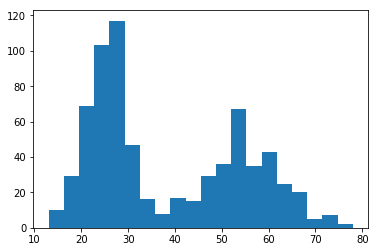

In [24]:
data = np.concatenate((stats.poisson.rvs(mu=25, size=400), stats.poisson.rvs(mu=55, size=300)))
plt.hist(data, bins=20)
plt.show()

# 2. ギブスサンプリング

まずは、MCMCの一つであるギブスサンプリングを実装する。  
アルゴリズムは以下の通り。  

#### 1. 潜在変数$s_n$をサンプリング（全てのサンプル$N$について）

$$
\begin{equation*}
\eta_k \propto \exp(x_n \ln \lambda_k - \lambda_k + \ln \pi_k) \{ s.t. \Sigma_{k=1}^{K} \eta_{n, k} = 1 \} \\
s_n \sim Cat(s_n | \eta_n) \\ 
\end{equation*}
$$

#### 2. パラメータ$\lambda_k$をサンプリング（全てのクラスタ$K$について）

$$
\begin{eqnarray*}
\hat a_k &=& \Sigma_{n=1}^{N} s_{n, k}x_n + a \\
\hat b_k &=& \Sigma_{n=1}^{N} s_{n, k} + b \\
\end{eqnarray*}
$$

$$
\begin{equation*}
\lambda_k \sim Gam(\lambda_k | \hat a_k, \hat b_k) \\
\end{equation*}
$$

#### 3. パラメータ$\pi$をサンプリング

$$
\begin{equation*}
\hat \alpha_k = \Sigma_{n=1}^{N} s_{n, k} + \alpha_k \\
\pi \sim Dir(\pi | \hat \alpha) \\
\end{equation*}
$$

#### 4. 上記ステップ1~3を繰り返す

In [4]:
def log_sum_exp(X):
    max_x = np.max(X, axis=1).reshape(-1, 1)
    return np.log(np.sum(np.exp(X - max_x), axis=1).reshape(-1, 1)) + max_x

In [25]:
# Data
X = data

# Constants
N = len(X)  # # of samples
K = 2  # # of clusters

# Parameters
lmd = np.ones(K)
pi = np.ones(K) / K

# Hyper-parameters
a = 1
b = 1
alpha = np.ones(K)

# Calculated results
sampled_lmd = np.zeros(K)
sampled_pi = np.zeros(K)

# Gibbs sampling
for i in range(100):
    # 1. Sample s_n
    tmp = np.dot(X.reshape(1, -1).T, np.log(lmd.reshape(1, -1))) - lmd.reshape(1, -1) + np.log(pi).reshape(1, -1)
    log_z = - log_sum_exp(tmp)
    eta = np.exp(tmp + log_z)
    
    S = np.zeros((N, K))
    for n in range(N):
        S[n] = stats.multinomial.rvs(n=1, p=eta[n], size=1)
    
    # 2. Sample lambda_k
    hat_a = np.dot(X, S).reshape(-1, 1) + a
    hat_b = S.sum(axis=0).reshape(-1, 1) + b
    lmd = stats.gamma.rvs(a=hat_a, scale=1./hat_b).T[0]
    sampled_lmd = np.vstack((sampled_lmd, lmd))

    # 3. Sample pi
    hat_alpha = S.sum(axis=0).reshape(1, -1) + alpha
    pi = stats.dirichlet.rvs(hat_alpha.reshape(-1), size=1)
    sampled_pi = np.vstack((sampled_pi, pi))

sampled_lmd = sampled_lmd[1:]
sampled_pi = sampled_pi[1:]
print('Finish')

Finish


ギブスサンプリングをした結果を下図に示す。  
もとの$\lambda$の値は、$\lambda_1=25, \lambda_2=55$なので、良い精度で求められている。

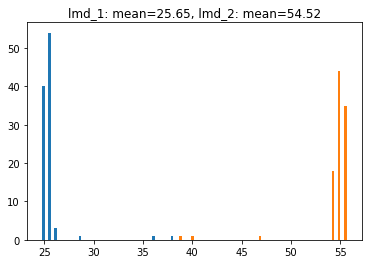

In [26]:
plt.hist(sampled_lmd, bins=50)
plt.title('lmd_1: mean={:.2f}, lmd_2: mean={:.2f}'.format(sampled_lmd[:, 0].mean(), sampled_lmd[:, 1].mean()))
plt.show()

次に、パラメータ$\pi$を求める。  
元データの混合比率が400 / (300 + 400) = 0.571なので、それなりの精度が出ている。

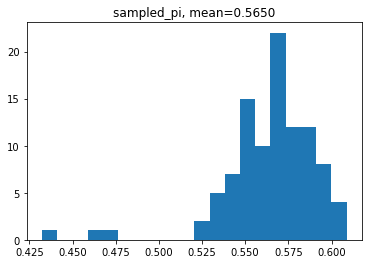

In [27]:
plt.hist(sampled_pi[:, 0], bins=20)
plt.title('sampled_pi, mean={:.4f}'.format(sampled_pi[:, 0].mean()))
plt.show()

In [108]:
bin_num = 20
prob_mat = stats.multinomial(1, )

bins = np.linspace(np.min(X), np.max(X), num=bin_num)
x_inds = np.digitize(X, bins)
norms = np.zeros(bin_num + 1)
cnts = np.zeros(bin_num + 1)

for x_ind, prob_n in zip(x_inds[:, 0], )

# 2. 変分推論

次に、平均場近似に基づく変分推論を実装する。  
アルゴリズムは以下の通り。  
ギブスサンプリングとの違いは2点ある。  

1. 潜在変数、パラメータの期待値を用いている
2. 各パラメータが独立の確率分布に従う


#### 1. 潜在変数$s_n$をサンプリング（全てのサンプル$N$について）

$$
\begin{equation*}
\eta_k \propto \exp(x_n \langle\ln \lambda_k \rangle - \langle \lambda_k \rangle + \langle \ln \pi_k \rangle) \{ s.t. \Sigma_{k=1}^{K} \eta_{n, k} = 1 \} \\
q(s_n) = Cat(s_n | \eta_n) \\ 
\end{equation*}
$$

#### 2. パラメータ$\lambda_k$をサンプリング（全てのクラスタ$K$について）

$$
\begin{eqnarray*}
\hat a_k &=& \Sigma_{n=1}^{N} \langle s_{n, k} \rangle x_n + a \\
\hat b_k &=& \Sigma_{n=1}^{N} \langle s_{n, k} \rangle + b \\
\end{eqnarray*}
$$

$$
\begin{equation*}
q(\lambda_k) = Gam(\lambda_k | \hat a_k, \hat b_k) \\
\end{equation*}
$$

#### 3. パラメータ$\pi$をサンプリング

$$
\begin{equation*}
\hat \alpha_k = \Sigma_{n=1}^{N} \langle s_{n, k} \rangle + \alpha_k \\
q(\pi) = Dir(\pi | \hat \alpha) \\
\end{equation*}
$$

#### 4. 上記ステップ1~3を繰り返す

In [89]:
# Variational Inference

# Data
X = data

# Constants
N = len(X)  # # of samples
K = 2  # # of clusters

# Hyper-parameters
a = np.ones(K)
b = np.ones(K)
alpha = np.random.rand(K)

hat_a = a.copy()
hat_b = b.copy()
hat_alpha = alpha.copy()

for i in range(100):
    # ----------------------------
    # 1. Update q(s_n)
    # ----------------------------
    
    # Calculate expected value of lmd
    expt_lmd = hat_a / hat_b
    expt_ln_lmd = digamma(hat_a) - np.log(hat_b)
    expt_ln_pi = digamma(hat_alpha) - digamma(hat_alpha.sum())
    
    # Update q(s_n)
    tmp = np.dot(X.reshape(-1, 1), expt_ln_lmd.reshape(1, -1)) - expt_lmd + expt_ln_pi
    eta = np.exp(tmp - log_sum_exp(tmp))
    
    # ----------------------------
    # 2. Update q(lmd_k)
    # ----------------------------
    
    hat_a = (eta * X.reshape(-1, 1)).sum(axis=0) + a
    hat_b = eta.sum(axis=0) + b
    # print(hat_a, hat_b)
    # lmd = stats.gamma(a=hat_a, scale=1./hat_b)
    
    # ----------------------------
    # 3. Update q(pi)
    # ----------------------------
    hat_alpha = eta.sum(axis=0) + alpha
        
print('Finish!')

Finish!


変分推論でハイパーパラメータ$\hat a_k, \hat b_k$を更新したときの、$q(\lambda_k) = Gam(\lambda_k | \hat a_k, \hat b_k)$を図示する。

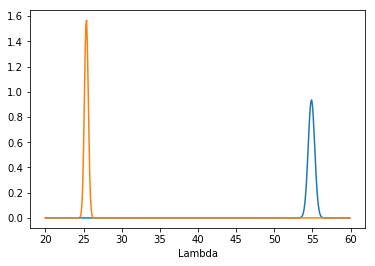

In [95]:
x_tmp = np.arange(20, 60, 0.1)
y_1 = stats.gamma.pdf(x_tmp, a=hat_a[0], scale=1./hat_b[0])
y_2 = stats.gamma.pdf(x_tmp, a=hat_a[1], scale=1./hat_b[1])
plt.plot(x_tmp, y_1)
plt.plot(x_tmp, y_2)
plt.xlabel('Lambda')

混合比率の0.57の辺りでピークを取っている。

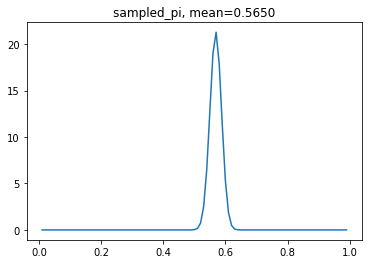

In [107]:
x_tmp = np.arange(0.01, 1, 0.01)
x_tmp = np.array([x_tmp, x_tmp[::-1]])
y_pi = stats.dirichlet.pdf(x_tmp, hat_alpha)
plt.plot(x_tmp[1], y_pi)
plt.title('sampled_pi, mean={:.4f}'.format(sampled_pi[:, 0].mean()))
plt.show()